In [1]:
import pandas as pd 
import os 
import pathlib 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import warnings
from tqdm import tqdm
import subprocess
warnings.filterwarnings("ignore")

##### general settings
path_to_main_output = "/media/hieunguyen/HNHD01/outdir/ampliconSeq/new/data_analysis"

path_to_02_output = os.path.join(path_to_main_output, "02_output")
path_to_03_output = os.path.join(path_to_main_output, "03_output")
os.system(f"mkdir -p {path_to_03_output}")

umidf = pd.read_csv(os.path.join(path_to_02_output, "all_umis.txt"), sep="\t")
umi_pct_df = pd.read_csv(os.path.join(path_to_02_output, "all_umis_pct.txt"), sep="\t")
entropydf = pd.read_csv(os.path.join(path_to_02_output, "umi_entropy.txt"), sep="\t")

umt_distance = 1

inputdir = f"/media/hieunguyen/HNHD01/outdir/ampliconSeq/from_VM/UMT_DISTANCE_{umt_distance}"

samplesheet = pd.read_csv(os.path.join("../experiments/SampleSheet_UMI_runs.csv"))
tmp_excluded_samples = ["45-TMS7E_S7545-S7745", "9-TMPL2S4_S7517-S7717"]
samplesheet = samplesheet[samplesheet["SampleID"].isin(tmp_excluded_samples) == False]
samplesheet["num_valid_umi_reads"] = samplesheet["SampleID"].apply(lambda x: umidf[x].sum())

path_to_unmapped_bam = os.path.join(inputdir, "BISMARK_ALIGNMENT_UNMAPPED_BAM")
path_to_connor_annotated = os.path.join(inputdir, "CONNOR_UMI_OUTPUT")
path_to_connor_fastq = os.path.join(inputdir, "CONNOR_UMI_OUTPUT")
path_to_final_bam = os.path.join(inputdir, "BISMARK_ALIGNMENT")
path_to_cov = os.path.join(inputdir, "BISMARK_COV")

samplesheet["unmapped_bam"] = samplesheet["SampleID"].apply(
    lambda x: [str(item) for item in pathlib.Path(path_to_unmapped_bam).glob(f"{x}*.UMIprocessed_bismark_bt2_pe.bam")][0] 
    if len([str(item) for item in pathlib.Path(path_to_unmapped_bam).glob(f"{x}*.UMIprocessed_bismark_bt2_pe.bam")]) == 1 else "not_available"
)
samplesheet["connor_annotated"] = samplesheet["SampleID"].apply(
    lambda x: [str(item) for item in pathlib.Path(path_to_connor_annotated).glob(f"{x}*.*annotated*.bam")][0] 
    if len([str(item) for item in pathlib.Path(path_to_connor_annotated).glob(f"{x}*.*annotated*.bam")]) == 1 else "not_available"
)
samplesheet["connor_fastq"] = samplesheet["SampleID"].apply(
    lambda x: [str(item) for item in pathlib.Path(path_to_connor_fastq).glob(f"{x}*.*R1*.fastq*")][0] 
    if len([str(item) for item in pathlib.Path(path_to_connor_fastq).glob(f"{x}*.*R1*.fastq*")]) == 1 else "not_available"
)
samplesheet["final_bam"] = samplesheet["SampleID"].apply(
    lambda x: [str(item) for item in pathlib.Path(path_to_final_bam).glob(f"{x}*.*connor*.bam")][0] 
    if len([str(item) for item in pathlib.Path(path_to_final_bam).glob(f"{x}*.*connor*.bam")]) == 1 else "not_available"
)
samplesheet["final_cov"] = samplesheet["SampleID"].apply(
    lambda x: [str(item) for item in pathlib.Path(path_to_cov).glob(f"{x}*.*connor*.cov")][0] 
    if len([str(item) for item in pathlib.Path(path_to_cov).glob(f"{x}*.*connor*.cov")]) == 1 else "not_available"
)


for col in ["unmapped_bam", "connor_annotated", "connor_fastq", "final_bam" , "final_cov"]:
    def _get_line_count(x):
        if x == "not_available":
            return 0
        try:
            if ".bam" in x:
                result = subprocess.run(f"samtools view {x} -c", shell=True, capture_output=True, text=True)
            elif ".fastq.gz" in x:
                result = subprocess.run(f"zcat {x} | wc -l", shell=True, capture_output=True, text=True)
            else:
                result = subprocess.run(f"cat {x} | wc -l", shell=True, capture_output=True, text=True)
            return int(result.stdout.strip())
        except Exception:
            return 0
    samplesheet[f"count_{col}"] = samplesheet[col].apply(_get_line_count)            

In [2]:
samplesheet[(samplesheet["unmapped_bam"] != "not_available") & 
            (samplesheet["final_cov"] != "not_available")]

,SampleID,FASTQ1,FASTQ2,num_valid_umi_reads,unmapped_bam,connor_annotated,connor_fastq,final_bam,final_cov,count_unmapped_bam,count_connor_annotated,count_connor_fastq,count_final_bam,count_final_cov
1,11-TML3S1_S7511-S7711,/mnt/GS-BACKUP05/FASTQ/2025/R7288/zatm/11-TML3...,/mnt/GS-BACKUP05/FASTQ/2025/R7288/zatm/11-TML3...,815024,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,6108,6108,68,34,13
2,12-TML3S2_S7512-S7712,/mnt/GS-BACKUP05/FASTQ/2025/R7288/zatm/12-TML3...,/mnt/GS-BACKUP05/FASTQ/2025/R7288/zatm/12-TML3...,796800,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,3744,3744,56,26,13
3,13-TML3S3_S7513-S7713,/mnt/GS-BACKUP05/FASTQ/2025/R7288/zatm/13-TML3...,/mnt/GS-BACKUP05/FASTQ/2025/R7288/zatm/13-TML3...,874550,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,3968,3968,64,32,13
4,14-TML3S4_S7514-S7714,/mnt/GS-BACKUP05/FASTQ/2025/R7288/zatm/14-TML3...,/mnt/GS-BACKUP05/FASTQ/2025/R7288/zatm/14-TML3...,1289061,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,17638,17638,60,2,13
5,15-TML3S5_S7515-S7715,/mnt/GS-BACKUP05/FASTQ/2025/R7288/zatm/15-TML3...,/mnt/GS-BACKUP05/FASTQ/2025/R7288/zatm/15-TML3...,1646809,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,38346,38346,88,44,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2-TMPL1S2_S7510-S7710,/mnt/GS-BACKUP05/FASTQ/2025/R7312/zatm/2-TMPL1...,/mnt/GS-BACKUP05/FASTQ/2025/R7312/zatm/2-TMPL1...,1531448,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,20376,20376,80,36,4
103,3-TMPL1S3_S7511-S7711,/mnt/GS-BACKUP05/FASTQ/2025/R7312/zatm/3-TMPL1...,/mnt/GS-BACKUP05/FASTQ/2025/R7312/zatm/3-TMPL1...,1617109,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,23926,23926,76,12,4
104,4-TMPL1S4_S7512-S7712,/mnt/GS-BACKUP05/FASTQ/2025/R7312/zatm/4-TMPL1...,/mnt/GS-BACKUP05/FASTQ/2025/R7312/zatm/4-TMPL1...,1721808,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,28394,28394,92,42,4
105,5-TMPL1S5_S7513-S7713,/mnt/GS-BACKUP05/FASTQ/2025/R7312/zatm/5-TMPL1...,/mnt/GS-BACKUP05/FASTQ/2025/R7312/zatm/5-TMPL1...,1472132,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,/media/hieunguyen/HNHD01/outdir/ampliconSeq/fr...,19788,19788,60,30,4


In [3]:
samplesheet[[item for item in samplesheet.columns if "count_" in item]]

,count_unmapped_bam,count_connor_annotated,count_connor_fastq,count_final_bam,count_final_cov
0,0,0,0,0,0
1,6108,6108,68,34,13
2,3744,3744,56,26,13
3,3968,3968,64,32,13
4,17638,17638,60,2,13
...,...,...,...,...,...
104,28394,28394,92,42,4
105,19788,19788,60,30,4
106,2,2,0,0,0
107,14,14,0,0,0


<Axes: xlabel='SampleID'>

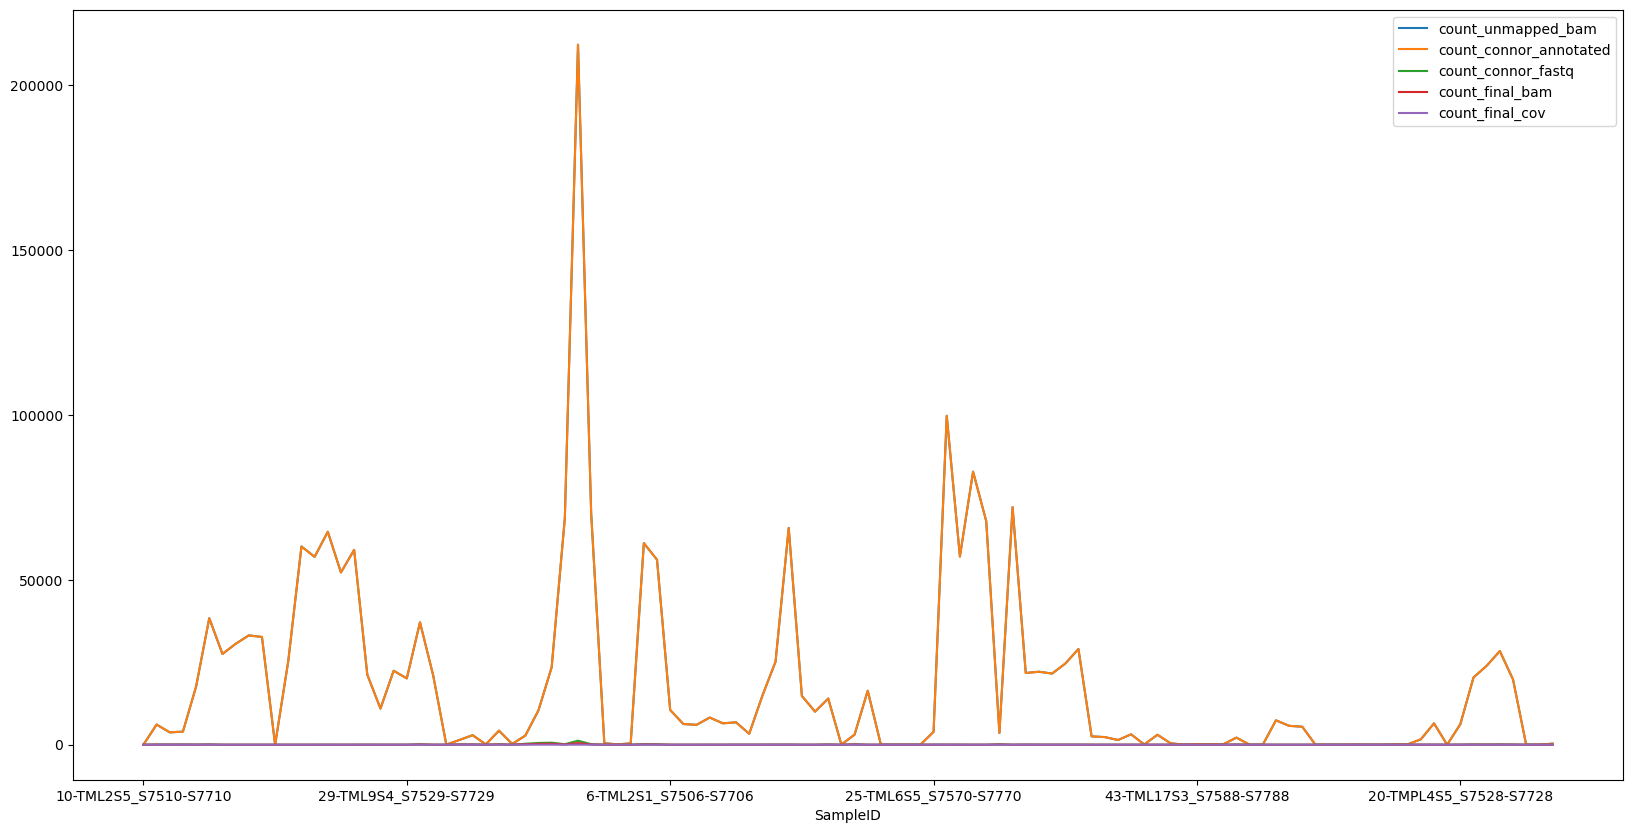

In [ ]:
samplesheet.plot( = "SampleID", y = [item for item in samplesheet.columns if "count_" in item], kind="line", figsize=(20, 10))